<a href="https://colab.research.google.com/github/connorrupnow/CHEM507_machinelearning/blob/main/bayesian_opt_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Optimization Simulation

The goal of this project is to build my own DIY bayesian optimizer using sklearn

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## Generate Response Surface

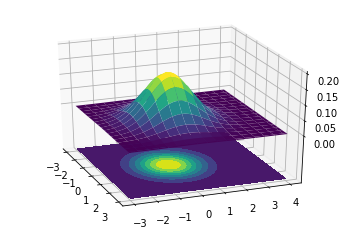

In [ ]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

parameters = {'num_points': 50,
              'X0': {'mean':0, 'std':1, 'high':3, 'low':-3}, #std dev is still not implemented
              'X1':{'mean':0, 'std':1,'high':4, 'low':-3}}

# Our 2-dimensional distribution will be over variables X0 and X1
N = parameters['num_points']
X0 = np.linspace(parameters['X0']['low'], parameters['X0']['high'], N)
X1 = np.linspace(parameters['X1']['low'], parameters['X1']['high'], N)
X0, X1 = np.meshgrid(X0, X1)

# Mean vector and covariance matrix
mu = np.array([parameters['X0']['mean'], parameters['X1']['mean']])
Sigma = np.array([[ 1. , 0], [0,  1]])

# Pack X0 and X1 into a single 3-dimensional array
pos = np.empty(X0.shape + (2,))
pos[:, :, 0] = X0
pos[:, :, 1] = X1

def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos.

    pos is an array constructed by packing the meshed arrays of variables
    x_1, x_2, x_3, ..., x_k into its _last_ dimension.

    """

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

# The distribution on the variables X0, X1 packed into pos.
Z = multivariate_gaussian(pos, mu, Sigma)

# Create a surface plot and projected filled contour plot under it.
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X0, X1, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                cmap=cm.viridis)

cset = ax.contourf(X0, X1, Z, zdir='z', offset=-0.15, cmap=cm.viridis)

# Adjust the limits, ticks and view angle
ax.set_zlim(-0.15,0.2)
ax.set_zticks(np.linspace(0,0.2,5))
ax.view_init(27, -21)

plt.show()

## Random Search

In [ ]:
num_guesses = 40
guess_array = [0,0,0,0]
current_highest = 0
for i in range(num_guesses):
  X0_guess = (np.random.sample()*(parameters['X0']['high'] - parameters['X0']['low']) - ((parameters['X0']['high'] - parameters['X0']['low'])/2))
  X1_guess = np.random.sample()*(parameters['X1']['high'] - parameters['X1']['low']) - ((parameters['X1']['high'] - parameters['X1']['low'])/2)
  Z_sample = multivariate_gaussian([X0_guess,X1_guess],mu,Sigma)
  if Z_sample > current_highest:
    current_highest = Z_sample
  new_row = [X0_guess,X1_guess,Z_sample,current_highest]
  guess_array = np.vstack([guess_array,new_row])

guess_array = np.delete(  guess_array, (0), axis=0)
#print(guess_array)

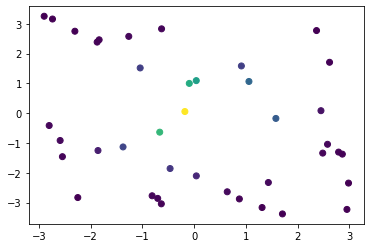

In [ ]:
plt.scatter(guess_array[:,0],guess_array[:,1],c=guess_array[:,2])

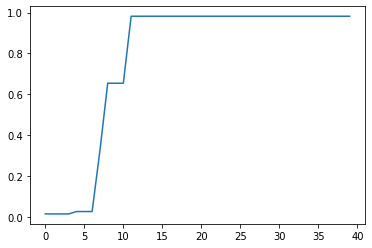

In [ ]:
max_val = multivariate_gaussian([0,0],mu,Sigma)
plt.plot(guess_array[:,3]/max_val)
#print('The first appearance of 90% is for random sample',np.where(guess_array[:,3]/max_val > 0.9)[0][0])

In [ ]:
# fig,[ax1,ax2] = plt.subplots(1,2)
# Z_max = np.max(Z)
# ax1.scatter(param_space[:, 0],param_space[:, 1],c=Z)
# ax1.scatter(guess_array[:,0],guess_array[:,1],c='r',alpha=0.2)

# ax2.scatter(param_space[:, 0],param_space[:, 1],c=Z)
# ax2.scatter(guess_array[:,0],guess_array[:,1],c='r',alpha=0.2)

In [ ]:
num_sims = 100
num_guesses = 1000
improvement = []

for i in range(num_sims):
  guess_array = [0,0,0,0]
  current_highest = 0
  for i in range(num_guesses):
    X0_guess = (np.random.sample()*(parameters['X0']['high'] - parameters['X0']['low']) - ((parameters['X0']['high'] - parameters['X0']['low'])/2))
    X1_guess = np.random.sample()*(parameters['X1']['high'] - parameters['X1']['low']) - ((parameters['X1']['high'] - parameters['X1']['low'])/2)
    Z_sample = multivariate_gaussian([X0_guess,X1_guess],mu,Sigma)
    if Z_sample > current_highest:
      current_highest = Z_sample
    new_row = [X0_guess,X1_guess,Z_sample,current_highest]
    guess_array = np.vstack([guess_array,new_row])
  
  guess_array = np.delete(  guess_array, (0), axis=0)

  improvement.append(guess_array[:,3])
#print(guess_array)
rand_improvement = improvement

0.9941235836362039
With  1000 guesses, 96.0 % of simulations reached 99% of the max value over 100 simulations


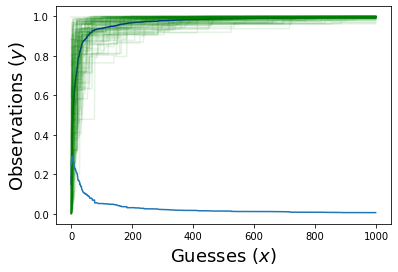

In [ ]:
num_above90 = 0

plt.plot(range(num_guesses), np.mean(improvement, axis=0)/max_val, c='b')
for i in range(num_sims):
  plt.plot(range(num_guesses), improvement[i][:]/max_val, c='g', alpha=.1)
  
  if improvement[i][-1]/max_val > 0.98:
    num_above90 += 1

plt.plot(range(num_guesses), np.std(improvement, axis=0)/max_val)

_ = plt.xlabel(r"Guesses ($x$)",size=18)
_ = plt.ylabel("Observations ($y$)",size=18)

print(max(np.mean(improvement, axis=0)/max_val))
print('With ',num_guesses, 'guesses,', round(num_above90/num_sims*100,2), '% of simulations reached 99% of the max value over', num_sims, 'simulations')

## Bayesian Optimization

In [ ]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel, DotProduct as C

# Define kernel object. 
kernel = RBF(length_scale=0.1, length_scale_bounds=(1e-5, 1e5))

gp = GaussianProcessRegressor(kernel=kernel,alpha=1e-12, n_restarts_optimizer=10)


In [ ]:
num_sims = 100
budget = 80
initial_random_guesses = 10

improvement = []

for _ in range(num_sims):
  
  # random sampling

  guess_array = [0,0,0,0]
  current_highest = 0
  for i in range(initial_random_guesses):
    # guess points
    X0_guess = (np.random.sample()*(parameters['X0']['high'] - parameters['X0']['low']) - ((parameters['X0']['high'] - parameters['X0']['low'])/2))
    X1_guess = np.random.sample()*(parameters['X1']['high'] - parameters['X1']['low']) - ((parameters['X1']['high'] - parameters['X1']['low'])/2)
    
    # objective evaluation
    Z_sample = multivariate_gaussian([X0_guess,X1_guess],mu,Sigma)
    
    # record current highest value
    if Z_sample > current_highest:
      current_highest = Z_sample
    
    #add new point to sample array
    new_row = [X0_guess,X1_guess,Z_sample,current_highest]
    guess_array = np.vstack([guess_array,new_row])
  
  guess_array = np.delete(  guess_array, (0), axis=0)

  # optimization turns on

  for i in range(budget - initial_random_guesses):

 ######################################
 # this is the optimizer code. It's not working :(

    # seperate inputs and objective outputs for model
    training_inputs = guess_array[:,0:2]
    training_labels = guess_array[:,2]

    param_space = np.empty((X0.flatten().shape[0],2))
    param_space[:, 0] = X0.flatten()
    param_space[:, 1] = X1.flatten()
    testing_inputs = param_space

    # fit model with inputs and objective outputs
    gp.fit(training_inputs, training_labels)

    # create a model of what it thinks the surface looks like
    y_pred = gp.predict(testing_inputs)
    # print(np.argmax(y_pred))

    #find x and y values of what the model thinks is the max value of that surface
    X0_guess, X1_guess = param_space[np.argmax(y_pred)]

###########################################


    #evaluate response at new guess
    Z_sample = multivariate_gaussian([X0_guess,X1_guess],mu,Sigma)
    
    # record highest sample
    if Z_sample > current_highest:
      current_highest = Z_sample
    new_row = [X0_guess,X1_guess,Z_sample,current_highest]
    print(new_row)
    guess_array = np.vstack([guess_array,new_row])
  

  improvement.append(guess_array[:,3])
opt_improvement = improvement

With  80 guesses, only 98.0 % of simulations reached 90% of the max value over 100 simulations


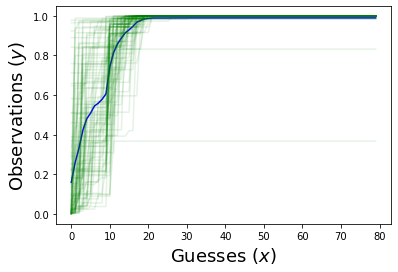

In [ ]:
num_above90 = 0

plt.plot(range(budget), np.mean(improvement, axis=0)/max_val, c='b')
for i in range(num_sims):
  plt.plot(range(budget), improvement[i][:]/max_val, c='g', alpha=.1)
  
  if improvement[i][-1]/max_val > 0.9:
    num_above90 += 1

ax = plt.gca()

#ax.vlines(initial_random_guesses-1,0,1)
_ = plt.xlabel(r"Guesses ($x$)",size=18)
_ = plt.ylabel("Observations ($y$)",size=18)

print('With ',budget, 'guesses, only', round(num_above90/num_sims*100,2), '% of simulations reached 90% of the max value over', num_sims, 'simulations')

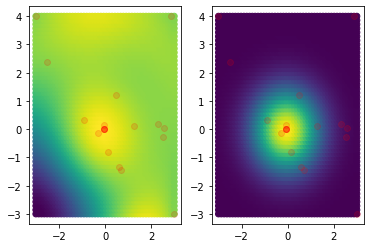

In [ ]:
fig,[ax1,ax2] = plt.subplots(1,2)
Z_max = np.max(Z)
ax1.scatter(param_space[:, 0],param_space[:, 1],c=y_pred)
ax1.scatter(guess_array[:,0],guess_array[:,1],c='r',alpha=0.15)

ax2.scatter(param_space[:, 0],param_space[:, 1],c=Z)
ax2.scatter(guess_array[:,0],guess_array[:,1],c='r',alpha=0.15)

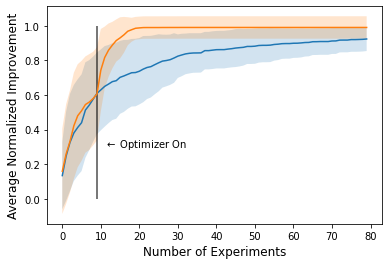

In [ ]:
plt.plot(range(num_guesses), np.mean(rand_improvement, axis=0)/max_val)
plt.fill_between(range(num_guesses),(np.mean(rand_improvement, axis=0)+np.std(rand_improvement, axis=0))/max_val,(np.mean(rand_improvement, axis=0)-np.std(rand_improvement, axis=0))/max_val,alpha=0.2)

plt.plot(range(num_guesses),np.mean(opt_improvement, axis=0)/max_val)
plt.fill_between(range(num_guesses),(np.mean(opt_improvement, axis=0)+np.std(opt_improvement, axis=0))/max_val,(np.mean(opt_improvement, axis=0)-np.std(opt_improvement, axis=0))/max_val,alpha=0.2)

ax = plt.gca()

ax.vlines(initial_random_guesses-1,0,1,alpha=0.7)
_ = plt.xlabel(r"Number of Experiments",size=12)
_ = plt.ylabel("Average Normalized Improvement",size=12)
_ = ax.text(initial_random_guesses,0.3,' $\leftarrow$ Optimizer On')

In [ ]:
np.mean(opt_improvement, axis=0)/max_val

array([0.15579796, 0.24441783, 0.33484609, 0.4092442 , 0.4606891 ,
       0.50584624, 0.55299492, 0.57606021, 0.59968007, 0.62642564,
       0.70605924, 0.79841977, 0.85716446, 0.89131751, 0.91612038,
       0.94183682, 0.96372991, 0.97495111, 0.981304  , 0.98896125])

## Noise

In [ ]:
# add noise
# multiplied by some random normal variable centered around 1 
# negative boltzmann distrubution for noise

num_sims = 100
budget = 80
noise_stddev = 0.15
improvement = []

for i in range(num_sims):
  guess_array = [0,0,0,0]
  current_highest = 0
  for i in range(budget):
    X0_guess = (np.random.sample()*(parameters['X0']['high'] - parameters['X0']['low']) - ((parameters['X0']['high'] - parameters['X0']['low'])/2))
    X1_guess = np.random.sample()*(parameters['X1']['high'] - parameters['X1']['low']) - ((parameters['X1']['high'] - parameters['X1']['low'])/2)
    Z_sample = multivariate_gaussian([X0_guess,X1_guess],mu,Sigma)*np.random.normal(1,noise_stddev)
    if Z_sample > current_highest:
      current_highest = Z_sample
    new_row = [X0_guess,X1_guess,Z_sample,current_highest]
    guess_array = np.vstack([guess_array,new_row])
  
  guess_array = np.delete(  guess_array, (0), axis=0)

  improvement.append(guess_array[:,3])
#print(guess_array)
noise_rand_improvement = improvement

## Bayesian Optimization
initial_random_guesses = 10
improvement = []

for _ in range(num_sims):
  
  # random sampling

  num_guesses = 50
  guess_array = [0,0,0,0]
  current_highest = 0
  for i in range(initial_random_guesses):
    # guess points
    X0_guess = (np.random.sample()*(parameters['X0']['high'] - parameters['X0']['low']) - ((parameters['X0']['high'] - parameters['X0']['low'])/2))
    X1_guess = np.random.sample()*(parameters['X1']['high'] - parameters['X1']['low']) - ((parameters['X1']['high'] - parameters['X1']['low'])/2)
    
    # objective evaluation
    Z_sample = multivariate_gaussian([X0_guess,X1_guess],mu,Sigma)*np.random.normal(1,noise_stddev)
    
    # record current highest value
    if Z_sample > current_highest:
      current_highest = Z_sample
    
    #add new point to sample array
    new_row = [X0_guess,X1_guess,Z_sample,current_highest]
    guess_array = np.vstack([guess_array,new_row])
  
  guess_array = np.delete(  guess_array, (0), axis=0)

  # optimization turns on

  for i in range(budget - initial_random_guesses):

 ######################################
 # this is the optimizer code

    # seperate inputs and objective outputs for model
    training_inputs = guess_array[:,0:2]
    training_labels = guess_array[:,2]

    param_space = np.empty((X0.flatten().shape[0],2))
    param_space[:, 0] = X0.flatten()
    param_space[:, 1] = X1.flatten()
    testing_inputs = param_space

    # fit model with inputs and objective outputs
    gp.fit(training_inputs, training_labels)

    # create a model of what it thinks the surface looks like
    y_pred = gp.predict(testing_inputs)
    # print(np.argmax(y_pred))

    #find x and y values of what the model thinks is the max value of that surface
    X0_guess, X1_guess = param_space[np.argmax(y_pred)]

###########################################


    #evaluate response at new guess
    Z_sample = multivariate_gaussian([X0_guess,X1_guess],mu,Sigma)*np.random.normal(1,noise_stddev)
    
    # record highest sample
    if Z_sample > current_highest:
      current_highest = Z_sample
    new_row = [X0_guess,X1_guess,Z_sample,current_highest]
    print(new_row)
    guess_array = np.vstack([guess_array,new_row])
  

  improvement.append(guess_array[:,3])
noise_opt_improvement = improvement

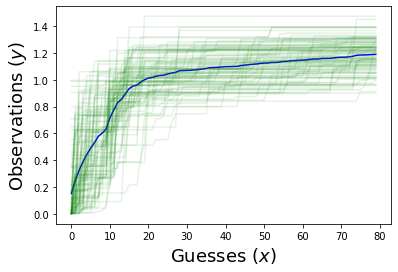

In [ ]:
plt.plot(range(budget), np.mean(noise_opt_improvement, axis=0)/max_val, c='b')
for i in range(num_sims):
  plt.plot(range(budget), noise_opt_improvement[i][:]/max_val, c='g', alpha=.1)

ax = plt.gca()

#ax.vlines(initial_random_guesses-1,0,1)
_ = plt.xlabel(r"Guesses ($x$)",size=18)
_ = plt.ylabel("Observations ($y$)",size=18)

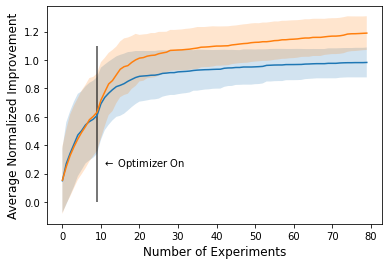

In [ ]:
plt.plot(range(budget), np.mean(noise_rand_improvement, axis=0)/max_val)
plt.fill_between(range(num_guesses),(np.mean(noise_rand_improvement, axis=0)+np.std(noise_rand_improvement, axis=0))/max_val,(np.mean(noise_rand_improvement, axis=0)-np.std(noise_rand_improvement, axis=0))/max_val,alpha=0.2)

plt.plot(range(budget),np.mean(noise_opt_improvement, axis=0)/max_val)
plt.fill_between(range(num_guesses),(np.mean(noise_opt_improvement, axis=0)+np.std(noise_opt_improvement, axis=0))/max_val,(np.mean(noise_opt_improvement, axis=0)-np.std(noise_opt_improvement, axis=0))/max_val,alpha=0.2)

ax = plt.gca()
#ax.legend(['random','optimization'])

ax.vlines(initial_random_guesses-1,0,1.1,alpha=0.7)
_ = plt.xlabel(r"Number of Experiments",size=12)
_ = plt.ylabel("Average Normalized Improvement",size=12)
_ = ax.text(initial_random_guesses-0.5,0.25,' $\leftarrow$ Optimizer On')

In [ ]:
from scipy.stats import maxwell
lambda_, N = 0.1, 0.2
k = np.linspace(0,10,100)
#f = (1-np.exp(-lambda_))*np.exp(-lambda_*k)/(1-np.exp(-lambda_*N))
f = np.sqrt(2/np.pi*(k**2))*np.exp(-(k**2)/2)
plt.plot(k,f)
maxwell.rvs(loc=0, scale=1, size=1, random_state=None)

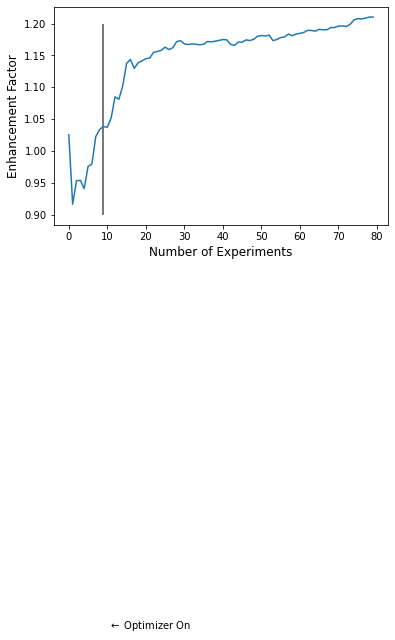

In [ ]:
plt.plot(range(budget), np.mean(noise_opt_improvement, axis=0)/np.mean(noise_rand_improvement, axis=0))

ax = plt.gca()
#ax.legend(['random','optimization'])

ax.vlines(initial_random_guesses-1,0.9,1.2,alpha=0.7)
_ = plt.xlabel(r"Number of Experiments",size=12)
_ = plt.ylabel("Enhancement Factor",size=12)
_ = ax.text(initial_random_guesses-0.5,0.25,' $\leftarrow$ Optimizer On')

Report the maximum of the model instead maybe?
qEHVI uses a bayesian nerual network
matern
RBF

## Acceleration and Enhancement Factor

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
x = np.linspace(0,50,51)

a = 25
b = -a

y = a/(-(x-b)) + 1
y2 = a/10/(-(x-b/10)) + 1

plt.plot(x,y)
ax = plt.gca()
ax.set_xlim(0,50)
ax.set_ylim(0,1)
ax.plot(x,y2)
ax.scatter(x[20],y[20])
ax.scatter([x[20],x[2]],[y2[20],0.44444])

ax.set_ylabel('Performance',size=12)
ax.set_xlabel('Number of Experiments',size=12)

In [ ]:
n=20
print(y[n],y2[n],y2[n]/y[n])

In [ ]:
2